In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from theano.tensor.nnet import conv2d
from theano.tensor.signal import downsample
%matplotlib inline

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
def getData(balance_ones=True):
    # images are 48x48 = 2304 size vectors
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open('../data/fer2013/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)

    if balance_ones:
        # balance the 1 class
        X0, Y0 = X[Y!=1, :], Y[Y!=1]
        X1 = X[Y==1, :]
        X1 = np.repeat(X1, 9, axis=0)
        X = np.vstack([X0, X1])
        Y = np.concatenate((Y0, [1]*len(X1)))

    return X, Y

In [3]:
def getImageData():
    X, Y = getData()
    N, D = X.shape
    d = int(np.sqrt(D))
    X = X.reshape(N, 1, d, d)
    return X, Y

In [4]:
def display_sample_image(X,Y):
    X,Y = shuffle(X,Y)
    labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    for i in xrange(16):
        plt.subplot(4,4,i)
        img = X[i].reshape(48, 48)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title(labels[Y[i]])
    plt.show()

In [5]:
X,Y = getImageData()

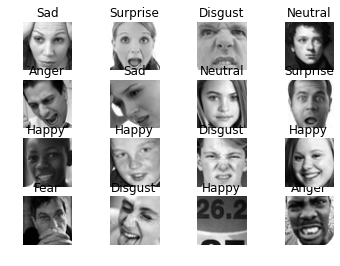

In [6]:
display_sample_image(X,Y)

In [7]:
def init_weight_and_bias(M1,M2):
    W = np.random.randn(M1,M2) / np.sqrt(M1 + M2)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)

In [8]:
def init_filter(shape,poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:] / np.prod(poolsz)))
    return w.astype(np.float32)

In [9]:
def error_rate(Y,T):
    return np.mean(Y!=T)

In [10]:
def y2indicator(y):
    N = len(y)
    K = len(set(y))
    y_ind = np.zeros((N,K))
    for i in xrange(N):
        y_ind[i,int(y[i])] = 1
    return y_ind

In [11]:
class HidenLayer(object):
    def __init__(self,M1,M2,an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W,b = init_weight_and_bias(M1,M2)
        self.W = theano.shared(W,'W_%s' % self.id)
        self.b = theano.shared(b,'b_%s' % self.id)
        self.params = [self.W,self.b]
    def forward(self,X):
        return T.nnet.relu(X.dot(self.W) + self.b)

In [12]:
class ConvPoolLayer(object):
    def __init__(self,mi,mo,fw=5,fh=5,poolsz=(2,2)):
        sz = (mo,mi,fw,fh)
        W0 = init_filter(sz,poolsz)
        self.W = theano.shared(W0)
        b0 = np.zeros(mo,dtype=np.float32)
        self.b = theano.shared(b0)
        self.poolsz = poolsz
        self.params = [self.W,self.b]
    def forward(self,X):
        conv_out = conv2d(input=X,filters=self.W)
        pool_out = downsample.max_pool_2d(
            input=conv_out,
            ds=self.poolsz,
            ignore_border=True
        )
        return T.nnet.relu(pool_out + self.b.dimshuffle('x', 0, 'x', 'x'))

In [13]:
class CNN(object):
    def __init__(self,convpool_layer_sizes,hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes
    def train(self, X, Y, lr=10e-5, mu=0.99, reg=10e-7, decay=0.99999, eps=10e-3, batch_sz=300, epochs=50, show_fig=True):
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        eps = np.float32(eps)
        
        #make validation set 
        X,Y = shuffle(X,Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.float32)
        X,Y = X[:-1000], Y[:-1000]
        X_valid, Y_valid = X[-1000:], Y[-1000:]
        Y_ind = y2indicator(Y)
        Y_valid_ind = y2indicator(Y_valid)
        #initialize convpool layers 
        N,c, width, height = X.shape
        mi = c
        outw = width
        outh = height
        self.convpool_layers = []
        for mo,fw,fh in self.convpool_layer_sizes:
            layer = ConvPoolLayer(mi,mo,fw,fh)
            self.convpool_layers.append(layer)
            outw = (outw - fw + 1) / 2
            outh = (outh - fh + 1) / 2
            mi = mo 
        #initialize the fully connected layers
        K = len(set(Y))
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*outw*outh
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HidenLayer(M1,M2,count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        # logistic regression layer 
        W, b = init_weight_and_bias(M1,K)
        self.W = theano.shared(W,'W_logreg')
        self.b = theano.shared(b,'b_logreg')
        
        # collect params for latter use 
        self.params = [self.W,self.b]
        for c in self.convpool_layers:
            self.params += c.params
        for h in self.hidden_layers:
            self.params + h.params
        # for momentum 
        dparams = [theano.shared(np.zeros(p.get_value().shape,dtype=np.float32)) for p in self.params]
        cache = [theano.shared(np.zeros(p.get_value().shape,dtype=np.float32)) for p in self.params]
        # setup theano functions and variables 
        th_X = T.tensor4('X',dtype='float32')
        th_Y = T.matrix('Y')
        P_Y = self.forward(th_X)
        rcost = T.sum([(p*p).sum() for p in self.params])
        cost = -(th_Y*T.log(P_Y)).sum() + rcost
        prediction = self.predict(th_X)
        cost_prediction_op = theano.function(
            inputs = [th_X,th_Y],
            outputs = [cost,prediction]
        )
        # updates 
        updates = [
            (p, p + mu*dp - lr*T.grad(cost,p)) for p, dp in zip(self.params, dparams)
        ] + [
            (dp, mu*dp - lr*T.grad(cost,p)) for p, dp in zip(self.params, dparams)
        ]
        train_op = theano.function(
            inputs = [th_X,th_Y],
            updates = updates
        )
        n_batches = N / batch_sz
        costs = []
        for i in xrange(epochs):
            for j in xrange(n_batches):
                X_batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Y_batch = Y_ind[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(X_batch,Y_batch)
                if j % 20 == 0:
                    c,p = cost_prediction_op(X_valid,Y_valid_ind)
                    costs.append(c)
                    e = error_rate(Y_valid,p)
                    print "i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e
        if show_fig:
            plt.plot(costs)
            plt.show()
    def forward(self,X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        Z = Z.flatten(ndim=2)
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax(Z.dot(self.W) + self.b)
    def predict(self,X):
        P_Y = self.forward(X)
        return T.argmax(P_Y,axis=1)

i: 0 j: 0 nb: 130 cost: 1979.6425271 error rate: 0.844
i: 0 j: 20 nb: 130 cost: 1958.54025424 error rate: 0.79
i: 0 j: 40 nb: 130 cost: 1947.51216149 error rate: 0.79
i: 0 j: 60 nb: 130 cost: 1940.65765083 error rate: 0.79
i: 0 j: 80 nb: 130 cost: 1932.98580706 error rate: 0.79
i: 0 j: 100 nb: 130 cost: 1921.02840912 error rate: 0.79
i: 0 j: 120 nb: 130 cost: 1909.70014262 error rate: 0.79
i: 1 j: 0 nb: 130 cost: 1909.13840067 error rate: 0.79
i: 1 j: 20 nb: 130 cost: 1895.04803097 error rate: 0.77
i: 1 j: 40 nb: 130 cost: 1885.9771378 error rate: 0.779
i: 1 j: 60 nb: 130 cost: 1889.68002236 error rate: 0.759
i: 1 j: 80 nb: 130 cost: 1867.38529623 error rate: 0.726
i: 1 j: 100 nb: 130 cost: 1855.57462001 error rate: 0.737
i: 1 j: 120 nb: 130 cost: 1817.99520671 error rate: 0.699
i: 2 j: 0 nb: 130 cost: 1812.89375412 error rate: 0.718
i: 2 j: 20 nb: 130 cost: 1817.79096985 error rate: 0.717
i: 2 j: 40 nb: 130 cost: 1829.75501359 error rate: 0.729
i: 2 j: 60 nb: 130 cost: 1849.33885777 e

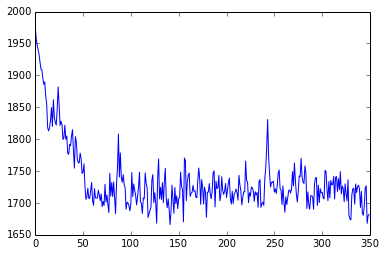

In [14]:
model = CNN(
    convpool_layer_sizes=[(20, 5, 5), (20, 5, 5)],
    hidden_layer_sizes=[500, 300],
)
model.train(X, Y)

In [26]:
results = model.predict(X[0].reshape(1,1,48,48))

In [27]:
results.eval()

ValueError: CorrMM received weight with wrong type.
Apply node that caused the error: CorrMM{valid, (1, 1)}(TensorConstant{[[[[ 0.274..156863]]]]}, Subtensor{::, ::, ::int64, ::int64}.0)
Toposort index: 7
Inputs types: [TensorType(float64, (True, True, False, False)), TensorType(float32, 4D)]
Inputs shapes: [(1, 1, 48, 48), (20, 1, 5, 5)]
Inputs strides: [(18432, 18432, 384, 8), (100, 100, -20, -4)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}(CorrMM{valid, (1, 1)}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-52fc03506314>", line 1, in <module>
    results = model.predict(X[0].reshape(1,1,48,48))
  File "<ipython-input-13-6ca918140511>", line 100, in predict
    P_Y = self.forward(X)
  File "<ipython-input-13-6ca918140511>", line 94, in forward
    Z = c.forward(Z)
  File "<ipython-input-12-d9980b2a1f76>", line 11, in forward
    conv_out = conv2d(input=X,filters=self.W)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.